# Designing RAG pipelines using LangChain and Evaluating them using Ragas
- https://medium.com/@rhitesh.ksingh99/designing-rag-pipelines-using-langchain-and-evaluating-them-using-ragas-4e7d09262bac

In [ ]:
!pip install langchain
# !pip install openai
!pip install openai==1.55.3
!pip install httpx==0.27.2
!pip install PyPDF2
!pip install pypdf
!pip install faiss-cpu
!pip install tiktoken
!pip install sentence-transformers
!pip install chromadb
!pip install -U langchain-openai
!pip install -U langchain-community
!pip install ragas datasets

  Using cached openai-1.55.3-py3-none-any.whl.metadata (24 kB)
Using cached openai-1.55.3-py3-none-any.whl (389 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.65.2
    Uninstalling openai-1.65.2:
      Successfully uninstalled openai-1.65.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.7 requires openai<2.0.0,>=1.58.1, but you have openai 1.55.3 which is incompatible.
  Using cached openai-1.65.2-py3-none-any.whl.metadata (27 kB)
Using cached openai-1.65.2-py3-none-any.whl (473 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.55.3
    Uninstalling openai-1.55.3:
      Successfully uninstalled openai-1.55.3


In [ ]:
import openai
openai.__version__

'1.65.2'

In [ ]:
import os
from google.colab import userdata
from google.colab import drive

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Basic RAG pipeline

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings

b_docs = []
loader = PyPDFLoader('/content/drive/MyDrive/Colab_Notebooks/RAG/bert.pdf')
b_docs.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap = 100)

docs = text_splitter.split_documents(b_docs)
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(docs, embeddings)

chroma_retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 4, "fetch_k": 10} # MMR (Maximal Marginal Relevance)
    )

## Prompt Template

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

## RAG Chain

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0) # avoiding any creative or speculative answers

rag_chain = (
    {"context": chroma_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

query = "What are the two main tasks on which BERT is pre-trained on?"
rag_chain.invoke(query)

'BERT is pre-trained on two main tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). These tasks help BERT understand the context and relationships between words in a sentence. The pre-training process involves using unsupervised tasks to train the model before fine-tuning it on specific downstream tasks.'

## Generalization

In [ ]:
# To generalise the entire process for use by various retrievers
def rag_chain(retriever):
  llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

  rag_chain = (
      {"context": retriever, "question": RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )
  return rag_chain

## Ground Truth

- [ARAGOG: Advanced RAG Output Grading](https://arxiv.org/html/2404.01037v1)
- This paper employed GPT-4 to generate a synthetic ground truth dataset derived from 13 NLP papers, resulting in 107 pairs of questions and answers.

In [ ]:
# Ground Truth Dataset of BERT paper
questions= [
         "What are the two main tasks BERT is pre-trained on?",
         "What model sizes are reported for BERT, and what are their specifications?",
         "How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?",
         "How does BERT's performance on the GLUE benchmark compare to previous state-of-the-art models?",
         "What significant improvements does BERT bring to the SQuAD v1.1,v2.0 and v13.5 tasks compared to prior models?",
         "Explain how BERT uses the 'masked LM' (MLM) for its pre-training.",
         "Discuss the impact of model size on BERT's performance across different tasks.",
         "What datasets were used for BERT's pre-training and why?"
     ]
ground_truths = [
         "Masked LM (MLM) and Next Sentence Prediction (NSP).",
         "BERTBASE (L=12, H=768, A=12, Total Parameters=110M) and BERTLARGE (L=24, H=1024, A=16, Total Parameters=340M).",
         "BERT uses a multi-layer bidirectional Transformer encoder architecture, allowing for minimal task-specific architecture modifications in fine-tuning.",
         "BERT achieved new state-of-the-art on the GLUE benchmark (80.5%), surpassing the previous best models.",
         "BERT set new records on SQuAD v1.1 and v2.0, significantly outperforming the top leaderboard systems at the time. Version 13.5 doesn't exist. ",
         "In MLM, a percentage of input tokens are masked randomly, and the model predicts these masked tokens based on their context.",
         "Larger BERT models consistently show better performance across tasks, indicating the importance of model size in achieving high accuracy.",
         "BooksCorpus (800M words) and English Wikipedia (2500M words), chosen for their document-level organization and volume of data."
     ]

## RAGAS : Evaluation Framework
- [RAGAS: Automated Evaluation of Retrieval Augmented Generation.](https://arxiv.org/abs/2309.15217)

- Retrieval metrics: context precision, context recall, context relevancy
- Generation metrics: faithfulness, answer relevancy
- End to end pipeline metrics: answer similarity, answer correctness

In [ ]:
import ragas
ragas.__version__

'0.2.13'

In [ ]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    # context_relevancy,
    answer_correctness,
    answer_similarity
)

from ragas.metrics._aspect_critic import harmfulness
from ragas import evaluate
from datasets import Dataset

- The `create_ragas_dataset` function takes in a `RAG chain` and `a retriever`. It processes each question in the `questions` list by using the RAG chain to generate answers, which are then appended to an initially empty list called `answers`.
- Simultaneously, the function uses the retriever to fetch `the top-k relevant documents` for each query, extracting their content and appending it to the `contexts` list.
- Finally, it compiles the data into a dictionary with keys: `question`, `answer`, `contexts`, and `ground_truth`. This dictionary is then converted into a dataset using `Dataset.from_dict(data)` and returned from the function.

In [ ]:
def create_ragas_dataset(rag_chain, retriever):
  answers = []
  contexts = []

  for query in questions:
    answers.append(rag_chain.invoke(query))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

  data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
  }

  dataset = Dataset.from_dict(data)
  return dataset

- This function provides a structured way to create a dataset that can be used to evaluate the performance of a RAG pipeline using the RAGAS framework, ensuring consistency and ease of comparison between different retrievers.
- The `evaluate_ragas_dataset` function takes in a RAGAS dataset, which is the dataset created for each retriever and its QA chain.
- It evaluates the dataset using a list of predefined metrics. The evaluation results are then returned in a dictionary format.

In [ ]:
def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        # context_relevancy,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

## Retrievers

### 1. Vector store backed retriever (Chroma retriever):

In [ ]:
chroma_retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 4, "fetch_k": 10}
    )

chroma_qa_chain = rag_chain(chroma_retriever)

query = "What are the two main tasks on which BERT is pre-trained on?"
chroma_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: Masked LM and Next Sentence Prediction (NSP). Masked LM involves predicting masked words in a sentence, while NSP involves determining if two sentences are consecutive or not. These tasks help BERT learn contextual relationships and improve performance on downstream tasks.'

In [ ]:
chroma_dataset = create_ragas_dataset(chroma_qa_chain, chroma_retriever)
chroma_result = evaluate_ragas_dataset(chroma_dataset)
chroma_result

<ipython-input-25-9a50d403342b>:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

{'context_precision': 0.7500, 'faithfulness': 0.8625, 'answer_relevancy': 0.9445, 'context_recall': 0.9375, 'answer_correctness': 0.7986, 'semantic_similarity': 0.8966}

### 2. Parent Document retriever:
- One of the easier ways of improving a retriever is to embed our documents into small chunks, and then retrieve a significant amount of additional context that “surrounds” the found context.
- [LangChain:Parent Document Retriever](https://python.langchain.com/docs/how_to/parent_document_retriever/)

- major steps:
  1. Data preprocessing: Breaking very long documents into manageable pieces
  2. Create embeddings: Convert pieces into numerical vectors for efficient search
  3. User query: User submits a question
  4. Chunk retrieval: Model retrieves the piece’s most similar to the embedding for the query
  5. Find parent document: Retrieve original documents or bigger pieces of them from which these pieces were taken
  6. Parent Document Retrieval: Retrieve full parent documents to provide more context for the response
  - [ref](https://dzone.com/articles/parent-document-retrieval-useful-technique-in-rag)
  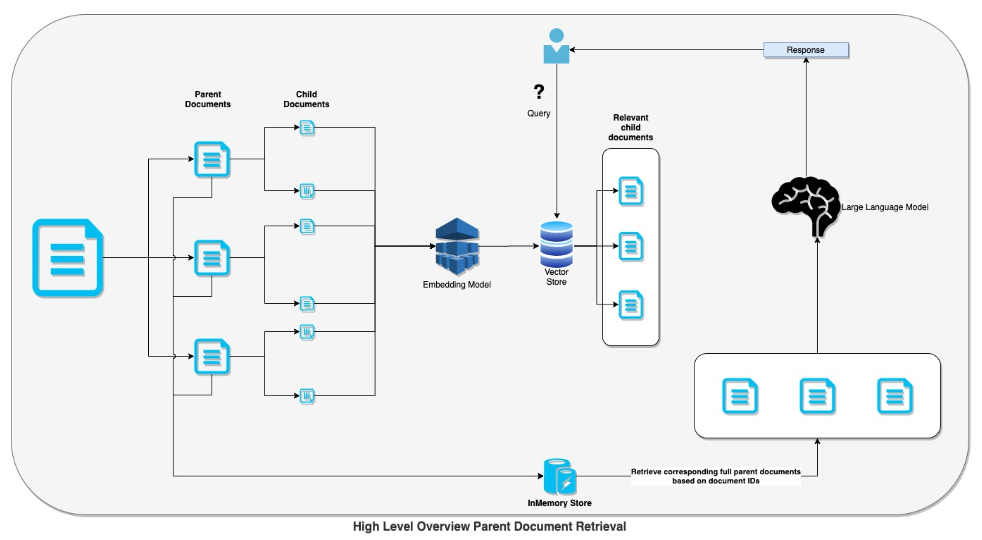

In [ ]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1500)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

vectorstore = Chroma(collection_name="split_parents", embedding_function=embeddings)

store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)
parent_document_retriever.add_documents(b_docs)

<ipython-input-29-4501669d9103>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="split_parents", embedding_function=embeddings)


In [ ]:
parent_qa_chain = rag_chain(parent_document_retriever)

query = "What are the two main tasks on which BERT is pre-trained on?"
parent_qa_chain.invoke(query)

""" BERT is pre-trained on the BooksCorpus and Wikipedia, which consist of a total of 3,300M words.
The two main tasks on which BERT is pre-trained are the masked language model (MLM) and the next sentence prediction (NSP) task.
These tasks enable bidirectionality and contribute significantly to the model's performance.
"""

" BERT is pre-trained on the BooksCorpus and Wikipedia, which consist of a total of 3,300M words.\nThe two main tasks on which BERT is pre-trained are the masked language model (MLM) and the next sentence prediction (NSP) task.\nThese tasks enable bidirectionality and contribute significantly to the model's performance.\n"

In [ ]:
pda_dataset = create_ragas_dataset(parent_qa_chain, parent_document_retriever)
pda_result = evaluate_ragas_dataset(pda_dataset)
pda_result

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

{'context_precision': 0.8507, 'faithfulness': 0.9844, 'answer_relevancy': 0.9309, 'context_recall': 0.8125, 'answer_correctness': 0.5415, 'semantic_similarity': 0.8804}

### 3. MultiQuery retriever:
- problem: retrieval may produce different results with `subtle changes` in query wording or if the embeddings do not capture the semantics of the data well.
- The retriever automates the process of prompt tuning by using an LLM to generate `multiple queries` from different perspectives for a given user input query.
- [LangChain:MultiQueryRetriever](https://python.langchain.com/docs/how_to/MultiQueryRetriever/)

In [ ]:
# Default prompt
# ref: https://python.langchain.com/api_reference/_modules/langchain/retrievers/multi_query.html#MultiQueryRetriever
from langchain_core.prompts.prompt import PromptTemplate
DEFAULT_QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is
    to generate 3 different versions of the given user
    question to retrieve relevant documents from a vector  database.
    By generating multiple perspectives on the user question,
    your goal is to help the user overcome some of the limitations
    of distance-based similarity search. Provide these alternative
    questions separated by newlines. Original question: {question}""",
)

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
    # prompt: BasePromptTemplate = DEFAULT_QUERY_PROMPT,
)

# MultiQuery retriever evaluation
multi_query_qa_chain = rag_chain(multi_query_retriever)
multi_query_dataset = create_ragas_dataset(multi_query_qa_chain, multi_query_retriever)
multi_query_result = evaluate_ragas_dataset(multi_query_dataset)
multi_query_result

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

{'context_precision': 0.5656, 'faithfulness': 0.7313, 'answer_relevancy': 0.9331, 'context_recall': 0.8125, 'answer_correctness': 0.6382, 'semantic_similarity': 0.8782}

In [ ]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

query = "What are the two main tasks on which BERT is pre-trained on?"
unique_docs = multi_query_retriever.invoke(query)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. What are the primary objectives that BERT is trained for?', '2. What are the key tasks that BERT undergoes pre-training for?', "3. What are the main areas of focus in BERT's pre-training process?"]


7